<a href="https://colab.research.google.com/github/Vaoikun/Sleep-Deprivation-Model/blob/main/Model_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
## These parameters are guesses

d = .0001      # rate of bonding
f = .00001        # rate of sticking
g = .0000001    # rate of flicking (had to make this very small, otherwise fib was going negative)

# added a coefficent to account for the fact that while the system is active
# it is clearing many more toxins that are being produced (ode wasnt behaving like it should without it)
# j = 145

awake_prod_rate = 0.025 # rate of production of toxins
sleep_prod_rate = awake_prod_rate * 0.89 # Sleeping decreases toxin production by 11%
maximal_conc = 1.5 # Maximum amount of concentration possible

# parameters
frequency = 2 * np.pi / 1.5   # ~1.5-hour cycles
decay = 1. / 20               # decay rate for deep sleep intensity


def sleep_state_function(t:float, when_asleep:list[tuple]=[(16, 24)], cycle_len:float=24.0):
    """
    This function takes the time, and what point in the day the individual goes
    to sleep, and returns whether they are awake or asleep.
    Parameters:
        t (float): The current time in hours
        when_asleep (list[tuple]): The time(s) the person is asleep. Defaults to 8 hours of sleep in one period.
        cycle_len (float): How long in hours one sleep cycle lasts. Defaults to 24.
    """
    time_of_day = t % cycle_len
    # Check if the time is within any of the times asleep
    for i in range(len(when_asleep)):
        if time_of_day >= when_asleep[i][0] and time_of_day <= when_asleep[i][1]:
            return True  # True if it is time to sleep

    # Otherwise, the person is awake
    return False


def G(t, x, sleep_start_time=[(16,24)], cycle_len=24.0): # glymphatic activity
    time_of_day = t % 24
    if sleep_state_function(t, sleep_start_time, cycle_len): # if asleep
        how_long_asleep = np.min([time_of_day - sleep_start_time[i][0] if time_of_day >= sleep_start_time[i][0] else np.inf for i in range(len(sleep_start_time))])
        return 1*(np.sin(frequency * (time_of_day - sleep_start_time[0][0]) - 1.57) + 1) / 2 * np.exp(-decay * how_long_asleep) * x[0] # model deep sleep
    else: # if awake
        return .00001 * x[0]


def P(t, x, sleep_start_time=[(16,24)], cycle_len=24.0): # production of toxins (return)
    if sleep_state_function(t, sleep_start_time, cycle_len): #if asleep
        return sleep_prod_rate * (1 - x[0] / maximal_conc)
    else: # if awake
        return awake_prod_rate * (1 - x[0] / maximal_conc)


def agg(t, x):
    return d * x[0] ** 2 + f * x[0] * x[1] - g * x[1]

def ode(t, x):
    dA_s_dt = P(t, x) - G(t, x) - agg(t, x)
    dA_f_dt = agg(t, x)
    return [dA_s_dt, dA_f_dt]

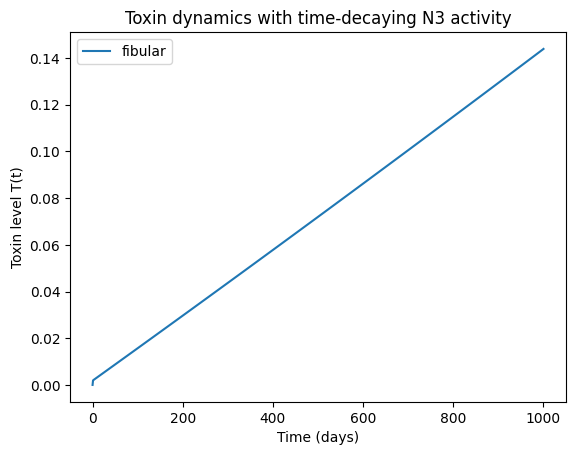

In [ ]:
t_span = (0, 24000) # adding in the agging function kept this function working properly
y0 = [1, 0]         # initial toxin level
sol = solve_ivp(ode, t_span, y0, max_step=0.5)

# plt.plot(sol.t, sol.y[0], label = "soluable")
plt.plot(sol.t / 24, sol.y[1], label = "fibular")
plt.xlabel("Time (days)")
plt.ylabel("Toxin level T(t)")
plt.title("Toxin dynamics with time-decaying N3 activity")
plt.legend()
plt.show()

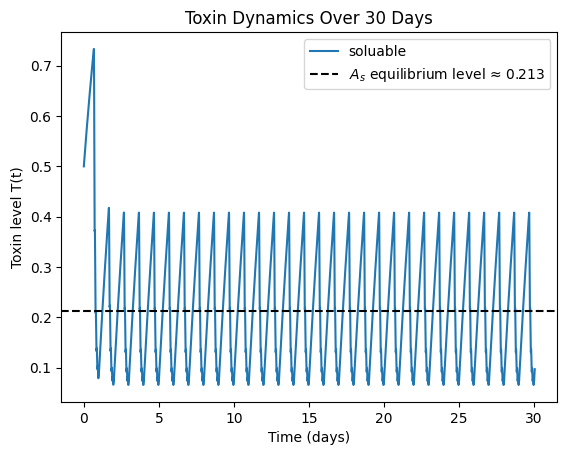

In [ ]:
num_days = 30
t_span_short = (0, 24 * num_days + 1) # adding in the agging function kept this function working properly
y0 = [0.5, 0]         # initial toxin level
sol_short = solve_ivp(ode, t_span_short, y0, max_step=0.1)

# Compute equilibrium
t = sol_short.t
As = sol_short.y[0]
Af = sol_short.y[1]
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_last_day = As[mask_last]
As_eq = As_last_day.mean()  # Equilibrium level as mean over the last day

plt.plot(sol_short.t / 24, sol_short.y[0], label = "soluable")
# plt.plot(sol_short.t, sol_short.y[1], label = "fibular")
plt.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ equilibrium level ≈ {As_eq:.3f}")
plt.xlabel("Time (days)")
plt.ylabel("Toxin level T(t)")
plt.title("Toxin Dynamics Over " + str(num_days) + " Days")
plt.legend()
plt.show()

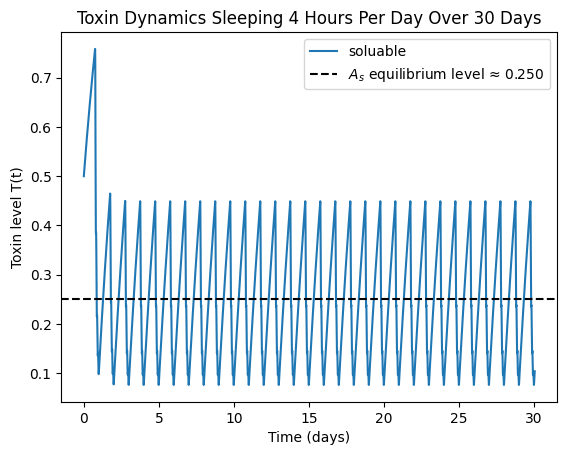

In [ ]:

# num_days = 30
when_asleep = [(18,24)]
t_span_dep = (0, 24 * num_days + 1) # adding in the agging function kept this function working properly
y0 = [0.5, 0]         # initial toxin level

def ode_deprived(t, x):
    dA_s_dt = P(t, x, when_asleep) - G(t, x, when_asleep) - agg(t, x)
    dA_f_dt = agg(t, x)
    return [dA_s_dt, dA_f_dt]

sol_6_hrs = solve_ivp(ode_deprived, t_span_dep, y0, max_step=.1)

# Compute equilibrium
t = sol_6_hrs.t
As = sol_6_hrs.y[0]
Af = sol_6_hrs.y[1] # fibular
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_last_day = As[mask_last]
As_eq = As_last_day.mean()  # Equilibrium level as mean over the last day

plt.plot(sol_6_hrs.t / 24, sol_6_hrs.y[0], label = "soluable")
# plt.plot(sol_short.t, sol_short.y[1], label = "fibular")
plt.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ equilibrium level ≈ {As_eq:.3f}")
plt.xlabel("Time (days)")
plt.ylabel("Toxin level T(t)")
plt.title("Toxin Dynamics Sleeping 4 Hours Per Day Over " + str(num_days) + " Days")
plt.legend()
plt.show()

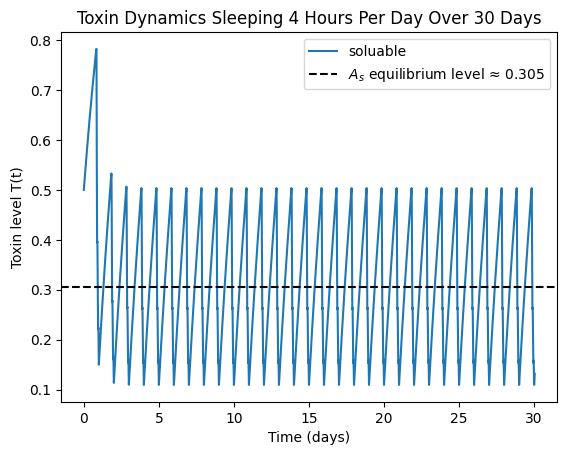

In [ ]:

# num_days = 30
when_asleep = [(20,24)]
t_span_dep = (0, 24 * num_days + 1) # adding in the agging function kept this function working properly
y0 = [0.5, 0]         # initial toxin level

def ode_deprived(t, x):
    dA_s_dt = P(t, x, when_asleep) - G(t, x, when_asleep) - agg(t, x)
    dA_f_dt = agg(t, x)
    return [dA_s_dt, dA_f_dt]

sol_dep = solve_ivp(ode_deprived, t_span_dep, y0, max_step=.1)

# Compute equilibrium
t = sol_dep.t
As = sol_dep.y[0]
Af = sol_dep.y[1] # fibular
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_last_day = As[mask_last]
As_eq = As_last_day.mean()  # Equilibrium level as mean over the last day

plt.plot(sol_dep.t / 24, sol_dep.y[0], label = "soluable")
# plt.plot(sol_short.t, sol_short.y[1], label = "fibular")
plt.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ equilibrium level ≈ {As_eq:.3f}")
plt.xlabel("Time (days)")
plt.ylabel("Toxin level T(t)")
plt.title("Toxin Dynamics Sleeping 4 Hours Per Day Over " + str(num_days) + " Days")
plt.legend()
plt.show()

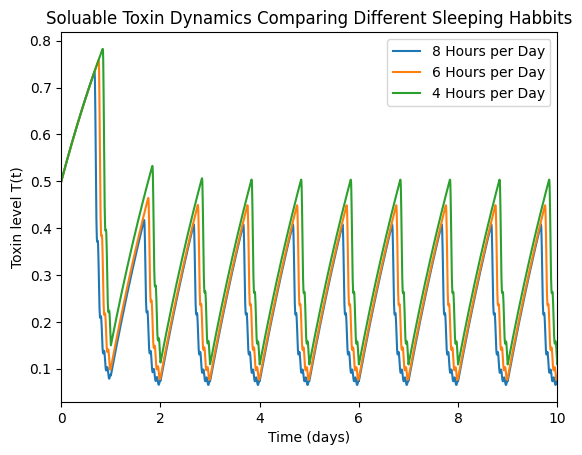

In [ ]:
plt.plot(sol_short.t / 24, sol_short.y[0], label = "8 Hours per Day")
plt.plot(sol_6_hrs.t / 24, sol_6_hrs.y[0], label = "6 Hours per Day")
plt.plot(sol_dep.t / 24, sol_dep.y[0], label = "4 Hours per Day")

plt.xlim(0, 10)
plt.xlabel("Time (days)")
plt.ylabel("Toxin level T(t)")
plt.title("Soluable Toxin Dynamics Comparing Different Sleeping Habbits")
plt.legend()
plt.show()

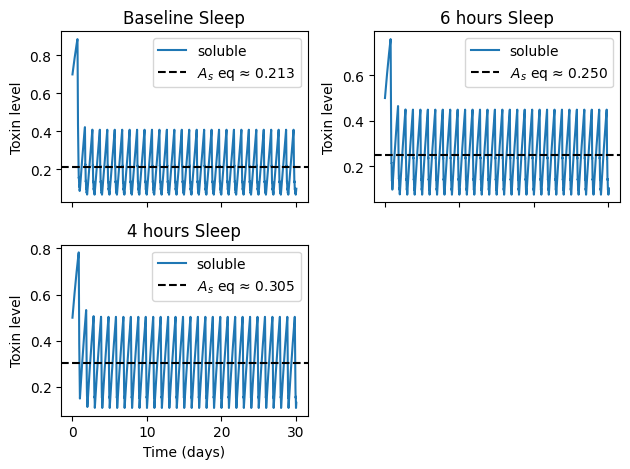

In [ ]:

fig, axes = plt.subplots(2, 2, sharex=True)
axes = axes.flatten()

ax = axes[0]
t = sol_short.t
As = sol_short.y[0]
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_ylabel("Toxin level")
ax.set_title("Baseline Sleep")
ax.legend()

ax = axes[1]
t = sol_6_hrs.t
As = sol_6_hrs.y[0]
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_ylabel("Toxin level")
ax.set_title("6 hours Sleep")
ax.legend()

ax = axes[2]
t = sol_dep.t
As = sol_dep.y[0]
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Toxin level")
ax.set_title("4 hours Sleep")
ax.legend()

axes[3].axis("off")
plt.tight_layout()
plt.show()

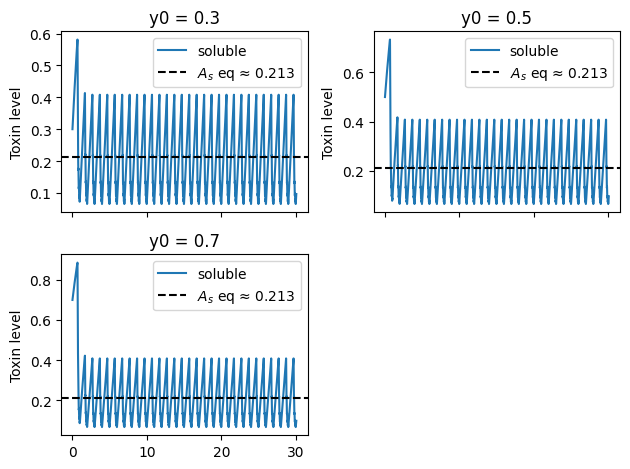

In [ ]:

fig, axes = plt.subplots(2, 2, sharex=True)
axes = axes.flatten()

y0 = [0.3, 0]
sol_short = solve_ivp(ode, t_span_short, y0, max_step=0.1)
ax = axes[0]
t = sol_short.t
As = sol_short.y[0]
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_ylabel("Toxin level")
ax.set_title("y0 = 0.3")
ax.legend()

y0 = [0.5, 0]
sol_short = solve_ivp(ode, t_span_short, y0, max_step=0.1)
ax = axes[1]
t = sol_short.t
As = sol_short.y[0]
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_ylabel("Toxin level")
ax.set_title("y0 = 0.5")
ax.legend()

y0 = [0.7, 0]
sol_short = solve_ivp(ode, t_span_short, y0, max_step=0.1)
ax = axes[2]
t = sol_short.t
As = sol_short.y[0]
t_last_start = 24 * num_days + 1 - 24.0
mask_last = t >= t_last_start
As_eq = As[mask_last].mean()

ax.plot(t/24, As, label="soluble")
ax.axhline(As_eq, linestyle="--", color='k', label=f"$A_s$ eq ≈ {As_eq:.3f}")
ax.set_ylabel("Toxin level")
ax.set_title("y0 = 0.7")
ax.legend()

axes[3].axis("off")
plt.tight_layout()
plt.show()

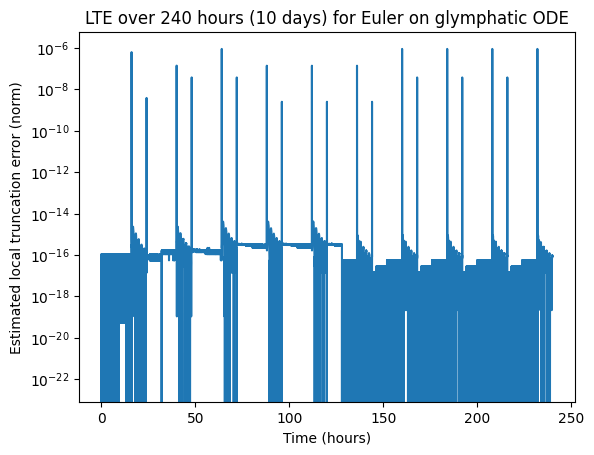

In [ ]:
def solve_ivp_stepper(f, t, y, h, rtol=1e-7, atol=1e-9):
    """
    Use solve_ivp to advance the solution from t to t+h, starting at y.

    This wrapper makes solve_ivp look like a one-step integrator:
        y_next = solve_ivp_stepper(f, t, y, h)
    """
    sol = solve_ivp(fun=f, t_span=(t, t + h), y0=np.asarray(y, dtype=float),
        t_eval=[t + h],      # only want solution at the end of the step
        rtol=rtol,
        atol=atol,
    )

    y_next = sol.y[:, -1]
    return y_next

def lte_step_doubling(f, stepper, t, y, h):
    """
    Estimate the **local truncation error (LTE)** of a one-step method
    using **step-doubling**.

      - Take one step of size h  → y_full
      - Take two steps of size h/2 → y_half2
      - These should match if the method were exact.
      - Their difference approximates the local error of the method.

    This does NOT use the exact solution y(t).
    """

    # Full step
    y_full = stepper(f, t, y, h)

    # Two half steps
    y_half = stepper(f, t, y, h/2)
    y_half2 = stepper(f, t + h/2, y_half, h/2)

    # LTE
    # The difference between the two approximations of y(t+h) measures how inaccurate the one-step method is.
    err = y_half2 - y_full

    # Use the Euclidean (L2) norm for a scalar “size of error”
    err_norm = np.linalg.norm(err, ord=2)

    return y_full, y_half2, err, err_norm

t0 = 0.0
tf = 24.0 * 10          # simulate 10 days
h  = 0.01
y0 = np.array([0.5, 0], dtype=float)

ts = [t0]
ys = [y0.copy()]
lte_vals = []          # store LTE norms for each step
lte_times = []         # store times where LTE is evaluated
t = t0
y = y0.copy()

while t < tf:
    if t + h > tf:
        h = tf - t

    # estimate LTE at (t, y)
    y_full, y_half2, err, err_norm = lte_step_doubling(ode, solve_ivp_stepper, t, y, h)

    t_next = t + h
    y_next = y_half2

    ts.append(t_next)
    ys.append(y_next.copy())

    lte_times.append(t_next)
    lte_vals.append(err_norm)

    t = t_next
    y = y_next

ts = np.array(ts)
ys = np.vstack(ys)
lte_times = np.array(lte_times)
lte_vals = np.array(lte_vals)

plt.figure()
plt.plot(lte_times[:-1], lte_vals[:-1]) # Omit the final value
plt.xlabel("Time (hours)")
plt.ylabel("Estimated local truncation error (norm)")
plt.title("LTE over 240 hours (10 days) for Euler on glymphatic ODE")
plt.yscale("log")  # log scale to help us observe easily
plt.show()

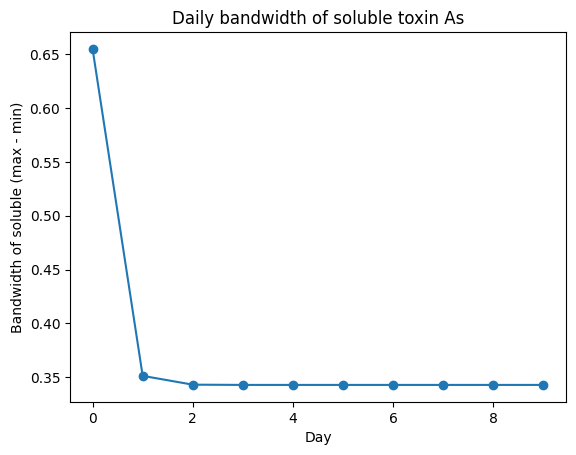

In [ ]:
t0 = 0.0
days_total = 10          # 10 days
T  = 24.0 * days_total
steps_per_day = 400      # resolution
N = steps_per_day * days_total
y0 = np.array([0.5, 0])  # initial condition
t_eval = np.linspace(t0, T, N+1)
sol = solve_ivp(fun=ode, t_span=(t0, T), y0=y0, t_eval=t_eval, rtol=1e-7, atol=1e-9)
t = sol.t
y = sol.y.T
As = y[:, 0]

def daily_bandwidths_soluble(t, As, cycle_len=24.0):
    """
    Compute daily max, min, and bandwidth of As for each cycle.
    """
    t0 = t[0]
    tf = t[-1]
    num_days = int((tf - t0) // cycle_len)

    day_indices = []
    daily_max = []
    daily_min = []
    daily_band = []

    for k in range(num_days):
        start = t0 + k * cycle_len
        end   = t0 + (k+1) * cycle_len
        mask = (t >= start) & (t < end)
        if not np.any(mask):
            continue

        As_day = As[mask]
        As_max = As_day.max()
        As_min = As_day.min()
        band   = As_max - As_min

        day_indices.append(k)
        daily_max.append(As_max)
        daily_min.append(As_min)
        daily_band.append(band)

    return (np.array(day_indices), np.array(daily_max), np.array(daily_min), np.array(daily_band))

day_idx, As_max, As_min, As_band = daily_bandwidths_soluble(t, As)

plt.figure()
plt.plot(day_idx, As_band, marker='o')
plt.xlabel("Day")
plt.ylabel("Bandwidth of soluble (max - min)")
plt.title("Daily bandwidth of soluble toxin As")
plt.show()

